# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_132  Q96KN2                            22.262
Sample_092  Q9H8L6                            17.689
Sample_063  P19022                            19.724
Sample_037  Q6ZVL6                            15.507
Sample_190  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   14.805
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                           
Sample_207  A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0-2;Q7Z6L0-3   15.296
Sample_062  B1AJZ9;B1AJZ9-4;H0YE38;Q5JYW6                               14.084
Sample_037  Q16799                                                      13.290
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.105
            A0A075B6Q5                 12.743
            A0A075B6R2                 12.422
            A0A075B6S5                 13.409
            A0A087WSY4                 11.970
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.610
            Q9UI40;Q9UI40-2            12.244
            Q9UIW2                     12.841
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.255
            Q9UP79                     11.590
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.242,15.050,16.842,19.863,15.632,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.610,19.067,...,15.528,15.576,14.032,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.635,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.830,17.705,17.039,15.898,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.490,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.411,15.345,17.084,18.708,14.249,19.433,12.058,11.300
Sample_207,15.739,16.877,15.469,16.898,15.059,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.096,12.728,13.566,13.162,11.806,13.089,12.316,12.934,13.095,11.869
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.425,19.067,16.127,...,12.328,11.572,12.424,13.374,12.050,13.234,13.678,13.456,12.619,12.914
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.989,12.488,12.456,12.191,13.132,13.090,12.582,13.717,12.256,12.456
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.519,12.949,12.984,12.647,12.000,13.037,12.352,11.915,13.489,12.117
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.243,11.658,13.443,11.202,13.495,13.090,12.489,13.217,12.131,12.336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.076,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 148.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.77it/s]

100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.26it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.70it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.57it/s]

100%|██████████| 5/5 [00:01<00:00,  4.49it/s]

100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.72it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.13it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.98it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.08it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.12it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.50it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.06it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.76it/s]

100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.44it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.98it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.15it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.19it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.20it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.26it/s]

100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.66it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.85it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.97it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.11it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.14it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.09it/s]

100%|██████████| 9/9 [00:02<00:00,  4.01it/s]

100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.87it/s]

 30%|███       | 3/10 [00:00<00:01,  4.83it/s]

 40%|████      | 4/10 [00:00<00:01,  4.65it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.58it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.05it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.07it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.19it/s]

100%|██████████| 10/10 [00:02<00:00,  3.01it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.24it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.98it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.16it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.53it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.03it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.87it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.70it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.01it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.20it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.08it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.08it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.41it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.30it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.46it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.55it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.57it/s]

100%|██████████| 12/12 [00:03<00:00,  3.25it/s]

100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.08it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.37it/s]

 31%|███       | 4/13 [00:01<00:02,  3.52it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.53it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.54it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.61it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.60it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.68it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.80it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.78it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.74it/s]

100%|██████████| 13/13 [00:03<00:00,  3.60it/s]

100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.55it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.42it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.04it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.73it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.69it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.55it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.23it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.97it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.79it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.64it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.59it/s]

100%|██████████| 14/14 [00:04<00:00,  2.69it/s]

100%|██████████| 14/14 [00:04<00:00,  3.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.53it/s]

 20%|██        | 3/15 [00:00<00:02,  4.14it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.31it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.82it/s]

 40%|████      | 6/15 [00:01<00:02,  3.82it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.83it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.25it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.94it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.80it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.67it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.76it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.13it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.041 0.015          0.885 0.196       0.169   
2             0.005 0.002      0.057 0.022          0.693 0.091       0.636   
3             0.004 0.001      0.039 0.010          0.776 0.101       0.722   
4             0.005 0.003      0.060 0.027          0.778 0.096       0.769   
5             0.004 0.002      0.043 0.015          0.771 0.094       0.764   
6             0.004 0.001      0.042 0.013          0.823 0.086       0.792   
7             0.004 0.002      0.044 0.014          0.830 0.088       0.790   
8             0.005 0.003      0.055 0.023          0.820 0.097       0.791   
9             0.005 0.003      0.055 0.021          0.804 0.085       0.812   
10            0.005 0.002      0.049 0.017          0.804 0.085       0.813   
11            0.005 0.003      0.042 0.015          0.803 0.088       0.811   
12            0.004 0.002      0.040 0.009          0.802 0.083       0.807   
13            0.004 0.001      0.037 0.008          0.803 0.086       0.805   
14            0.005 0.002      0.052 0.021          0.817 0.087       0.808   
15            0.006 0.002      0.054 0.018          0.827 0.085       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.274 0.122                  0.576 0.042        0.860   
2          0.109   0.658 0.083                  0.713 0.064        0.804   
3          0.102   0.743 0.079                  0.782 0.063        0.878   
4          0.110   0.768 0.078                  0.802 0.064        0.881   
5          0.109   0.761 0.077                  0.796 0.063        0.878   
6          0.096   0.803 0.072                  0.832 0.060        0.899   
7          0.093   0.805 0.072                  0.834 0.060        0.899   
8          0.091   0.802 0.075                  0.830 0.063        0.897   
9          0.098   0.804 0.074                  0.833 0.064        0.912   
10         0.097   0.805 0.072                  0.833 0.063        0.911   
11         0.100   0.803 0.076                  0.831 0.065        0.911   
12         0.098   0.801 0.072                  0.830 0.061        0.910   
13         0.101   0.800 0.074                  0.829 0.062        0.907   
14         0.100   0.809 0.076                  0.837 0.064        0.908   
15         0.093   0.816 0.072                  0.843 0.061        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.827 0.088        210.000 0.000  
2          0.067                  0.762 0.088        210.000 0.000  
3          0.054                  0.839 0.077        210.000 0.000  
4          0.053                  0.843 0.076        210.000 0.000  
5          0.053                  0.840 0.076        210.000 0.000  
6          0.052                  0.879 0.063        210.000 0.000  
7          0.053                  0.881 0.065        210.000 0.000  
8          0.053                  0.878 0.066        210.000 0.000  
9          0.050                  0.900 0.055        210.000 0.000  
10         0.051                  0.899 0.056        210.000 0.000  
11         0.050                  0.898 0.055        210.000 0.000  
12         0.051                  0.897 0.057        210.000 0.000  
13         0.051                  0.893 0.056        210.000 0.000  
14         0.052                  0.892 0.057        210.000 0.000  
15         0.050                  0.893 0.057 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 524.35it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

100%|██████████| 2/2 [00:00<00:00,  7.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.71it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.33it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.61it/s]

100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.94it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.94it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.00it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.18it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.15it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.58it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.67it/s]

100%|██████████| 7/7 [00:01<00:00,  3.10it/s]

100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.80it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.87it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.86it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.86it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.13it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  2.95it/s]

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.18it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.55it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.66it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.19it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.07it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.94it/s]

100%|██████████| 9/9 [00:03<00:00,  2.06it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.58it/s]

 30%|███       | 3/10 [00:00<00:02,  3.23it/s]

 40%|████      | 4/10 [00:01<00:01,  3.08it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.18it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.45it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.41it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.34it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.62it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.56it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.23it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.21it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.72it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.86it/s]

100%|██████████| 11/11 [00:04<00:00,  2.93it/s]

100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.55it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.15it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.01it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.94it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.05it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.02it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.90it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.63it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.43it/s]

100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.29it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.17it/s]

 31%|███       | 4/13 [00:01<00:03,  2.76it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.48it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.26it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.22it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.29it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.40it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.39it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.33it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.42it/s]

100%|██████████| 13/13 [00:05<00:00,  2.70it/s]

100%|██████████| 13/13 [00:05<00:00,  2.54it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.79it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.64it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.08it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.85it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.99it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.98it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.98it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.93it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.88it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.00it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.09it/s]

100%|██████████| 14/14 [00:04<00:00,  3.23it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.28it/s]

 20%|██        | 3/15 [00:00<00:02,  4.31it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.01it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.63it/s]

 40%|████      | 6/15 [00:01<00:02,  3.44it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.35it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.27it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.32it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.77it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.51it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.40it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.33it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.49it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

100%|██████████| 15/15 [00:05<00:00,  2.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.043 0.013          0.000 0.000       0.000   
2             0.004 0.002      0.049 0.018          0.790 0.103       0.673   
3             0.004 0.002      0.039 0.010          0.777 0.111       0.699   
4             0.004 0.001      0.039 0.008          0.790 0.096       0.764   
5             0.004 0.001      0.041 0.012          0.790 0.093       0.771   
6             0.005 0.002      0.050 0.018          0.785 0.094       0.771   
7             0.005 0.002      0.045 0.016          0.781 0.093       0.769   
8             0.005 0.002      0.045 0.015          0.768 0.098       0.762   
9             0.004 0.002      0.038 0.013          0.789 0.100       0.759   
10            0.005 0.002      0.049 0.017          0.824 0.093       0.804   
11            0.005 0.002      0.048 0.017          0.820 0.092       0.804   
12            0.004 0.001      0.037 0.009          0.823 0.091       0.816   
13            0.004 0.001      0.039 0.011          0.825 0.092       0.814   
14            0.004 0.001      0.047 0.017          0.808 0.095       0.804   
15            0.005 0.003      0.043 0.013          0.823 0.095       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.116   0.719 0.088                  0.769 0.065        0.863   
3          0.138   0.727 0.100                  0.774 0.075        0.870   
4          0.112   0.771 0.075                  0.805 0.063        0.896   
5          0.114   0.773 0.074                  0.808 0.061        0.898   
6          0.111   0.771 0.074                  0.805 0.061        0.898   
7          0.117   0.768 0.075                  0.803 0.062        0.896   
8          0.118   0.758 0.081                  0.794 0.067        0.892   
9          0.120   0.764 0.076                  0.801 0.062        0.905   
10         0.091   0.809 0.068                  0.837 0.058        0.918   
11         0.095   0.807 0.069                  0.835 0.057        0.918   
12         0.101   0.815 0.074                  0.843 0.063        0.918   
13         0.103   0.814 0.074                  0.842 0.062        0.918   
14         0.108   0.801 0.079                  0.830 0.066        0.916   
15         0.108   0.807 0.077                  0.836 0.064        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.086        210.000 0.000  
2          0.055                  0.833 0.076        210.000 0.000  
3          0.057                  0.832 0.076        210.000 0.000  
4          0.050                  0.868 0.066        210.000 0.000  
5          0.052                  0.869 0.068        210.000 0.000  
6          0.050                  0.869 0.065        210.000 0.000  
7          0.050                  0.865 0.066        210.000 0.000  
8          0.053                  0.864 0.066        210.000 0.000  
9          0.048                  0.878 0.060        210.000 0.000  
10         0.044                  0.895 0.056        210.000 0.000  
11         0.044                  0.894 0.057        210.000 0.000  
12         0.044                  0.895 0.054        210.000 0.000  
13         0.044                  0.895 0.054        210.000 0.000  
14         0.046                  0.894 0.055        210.000 0.000  
15         0.042                  0.902 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 275.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 30.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.13it/s]

100%|██████████| 3/3 [00:00<00:00, 22.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.65it/s]

100%|██████████| 4/4 [00:00<00:00, 13.11it/s]

100%|██████████| 4/4 [00:00<00:00, 13.46it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.67it/s]

100%|██████████| 5/5 [00:00<00:00, 18.55it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.11it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.96it/s]

100%|██████████| 6/6 [00:00<00:00, 13.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.69it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.83it/s]

100%|██████████| 7/7 [00:00<00:00, 16.51it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.21it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.73it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.27it/s]

100%|██████████| 8/8 [00:00<00:00, 12.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.07it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.77it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.05it/s]

100%|██████████| 9/9 [00:00<00:00, 13.30it/s]

100%|██████████| 9/9 [00:00<00:00, 13.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.93it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.02it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.89it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.72it/s]

100%|██████████| 10/10 [00:00<00:00, 11.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.51it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.19it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.63it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.74it/s]

100%|██████████| 11/11 [00:00<00:00, 11.91it/s]

100%|██████████| 11/11 [00:00<00:00, 12.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.21it/s]

 50%|█████     | 6/12 [00:00<00:00, 20.24it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 15.75it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.62it/s]

100%|██████████| 12/12 [00:00<00:00, 14.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 24.26it/s]

 46%|████▌     | 6/13 [00:00<00:00, 20.12it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 17.21it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 16.69it/s]

100%|██████████| 13/13 [00:00<00:00, 16.61it/s]

100%|██████████| 13/13 [00:00<00:00, 17.43it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.63it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.77it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.77it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.86it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.94it/s]

100%|██████████| 14/14 [00:00<00:00, 16.51it/s]

100%|██████████| 14/14 [00:00<00:00, 16.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 28.67it/s]

 40%|████      | 6/15 [00:00<00:00, 20.21it/s]

 60%|██████    | 9/15 [00:00<00:00, 16.49it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 17.23it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 17.04it/s]

100%|██████████| 15/15 [00:00<00:00, 16.79it/s]

100%|██████████| 15/15 [00:00<00:00, 17.54it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.002      0.062 0.023          0.000 0.000       0.000   
2             0.004 0.002      0.048 0.020          0.687 0.118       0.445   
3             0.005 0.003      0.062 0.032          0.670 0.120       0.498   
4             0.005 0.002      0.051 0.022          0.663 0.114       0.456   
5             0.004 0.002      0.045 0.016          0.662 0.118       0.488   
6             0.004 0.002      0.041 0.013          0.659 0.111       0.493   
7             0.004 0.001      0.038 0.009          0.663 0.120       0.502   
8             0.005 0.003      0.047 0.018          0.664 0.116       0.500   
9             0.004 0.000      0.036 0.003          0.679 0.099       0.615   
10            0.005 0.002      0.050 0.021          0.686 0.099       0.632   
11            0.004 0.001      0.036 0.004          0.676 0.102       0.632   
12            0.005 0.002      0.048 0.017          0.677 0.104       0.632   
13            0.005 0.003      0.046 0.019          0.669 0.101       0.630   
14            0.005 0.003      0.054 0.022          0.664 0.107       0.629   
15            0.005 0.002      0.049 0.020          0.699 0.091       0.666   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.708   
2          0.108   0.531 0.096                  0.645 0.057        0.728   
3          0.118   0.562 0.098                  0.655 0.069        0.733   
4          0.121   0.532 0.105                  0.641 0.068        0.743   
5          0.118   0.554 0.100                  0.651 0.067        0.756   
6          0.115   0.556 0.095                  0.651 0.062        0.756   
7          0.117   0.564 0.099                  0.655 0.069        0.757   
8          0.117   0.562 0.099                  0.655 0.066        0.752   
9          0.115   0.640 0.091                  0.700 0.073        0.783   
10         0.113   0.653 0.091                  0.709 0.072        0.789   
11         0.116   0.647 0.088                  0.702 0.070        0.791   
12         0.115   0.647 0.088                  0.703 0.070        0.788   
13         0.113   0.642 0.085                  0.698 0.068        0.783   
14         0.119   0.639 0.093                  0.695 0.075        0.781   
15         0.114   0.676 0.081                  0.726 0.065        0.790   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.683 0.078        210.000 0.000  
2          0.061                  0.678 0.075        210.000 0.000  
3          0.065                  0.682 0.081        210.000 0.000  
4          0.068                  0.706 0.078        210.000 0.000  
5          0.062                  0.721 0.076        210.000 0.000  
6          0.059                  0.720 0.073        210.000 0.000  
7          0.061                  0.718 0.076        210.000 0.000  
8          0.062                  0.713 0.076        210.000 0.000  
9          0.069                  0.759 0.073        210.000 0.000  
10         0.072                  0.765 0.080        210.000 0.000  
11         0.073                  0.765 0.081        210.000 0.000  
12         0.072                  0.760 0.082        210.000 0.000  
13         0.072                  0.754 0.084        210.000 0.000  
14         0.072                  0.751 0.084        210.000 0.000  
15         0.069                  0.752 0.087 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,15,1
score_time,4,6,1
test_precision,1,13,15
test_recall,10,12,15
test_f1,15,12,15
test_balanced_accuracy,15,12,15
test_roc_auc,9,15,11
test_average_precision,9,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.93it/s]

 20%|██        | 3/15 [00:00<00:02,  4.82it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.38it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.05it/s]

 40%|████      | 6/15 [00:01<00:02,  4.06it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.40it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.84it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.69it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.65it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.82it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.88it/s]

100%|██████████| 15/15 [00:04<00:00,  2.86it/s]

100%|██████████| 15/15 [00:04<00:00,  3.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.04it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.94it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 16.70it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 16.66it/s]

100%|██████████| 11/11 [00:00<00:00, 15.83it/s]

100%|██████████| 11/11 [00:00<00:00, 16.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.38it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.52it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.54it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.83it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.45it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.25it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.00it/s]

100%|██████████| 9/9 [00:02<00:00,  2.97it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


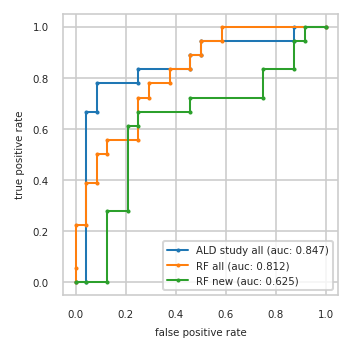

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.042 0.000
2          0.042 0.667  0.000 0.222  0.125 0.000
3          0.083 0.667  0.042 0.222  0.125 0.278
4          0.083 0.778  0.042 0.389  0.208 0.278
5          0.250 0.778  0.083 0.389  0.208 0.611
6          0.250 0.833  0.083 0.500  0.250 0.611
7          0.458 0.833  0.125 0.500  0.250 0.667
8          0.458 0.889  0.125 0.556  0.458 0.667
9          0.500 0.889  0.250 0.556  0.458 0.722
10         0.500 0.944  0.250 0.722  0.750 0.722
11         0.875 0.944  0.292 0.722  0.750 0.833
12         0.875 1.000  0.292 0.778  0.875 0.833
13         1.000 1.000  0.375 0.778  0.875 0.944
14           NaN   NaN  0.375 0.833  0.917 0.944
15           NaN   NaN  0.458 0.833  0.917 1.000
16           NaN   NaN  0.458 0.889  1.000 1.000
17           NaN   NaN  0.500 0.889    NaN   NaN
18           NaN   NaN  0.500 0.944    NaN   NaN
19           NaN   NaN  0.583 0.944    NaN   NaN
20           NaN   NaN  0.583 1.000    NaN   NaN
21           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,Q8NFY4;Q8NFY4-6,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,G3XAI2;P07942,A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2,P31150
3,B1AHL2;P23142-4,P00492,J3KSJ8;Q9UD71;Q9UD71-2
4,P61981,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P04075,P61981,A0A0J9YW36;Q9NZ72;Q9NZ72-2
6,P14174,P25189;P25189-2,P31321
7,Q9Y2T3;Q9Y2T3-3,P04075,Q504Y2
8,Q99983,P14174,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


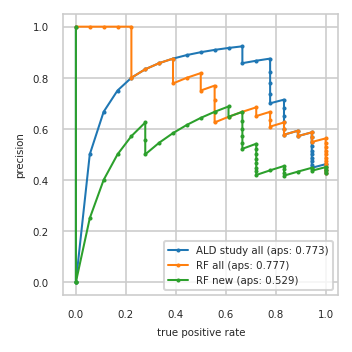

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.447 0.944     0.474 1.000     0.447 0.944
5          0.459 0.944     0.486 1.000     0.432 0.889
6          0.472 0.944     0.500 1.000     0.417 0.833
7          0.486 0.944     0.514 1.000     0.429 0.833
8          0.500 0.944     0.529 1.000     0.441 0.833
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.438 0.778
11         0.548 0.944     0.548 0.944     0.419 0.722
12         0.567 0.944     0.567 0.944     0.433 0.722
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.571 0.889     0.571 0.889     0.464 0.722
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.577 0.833     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.778 0.778     0.667 0.667     0.667 0.667
25         0.824 0.778     0.647 0.611     0.647 0.611
26         0.875 0.778     0.625 0.556     0.688 0.611
27         0.867 0.722     0.667 0.556     0.667 0.556
28         0.857 0.667     0.714 0.556     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.400 0.111
38         0.750 0.167     1.000 0.222     0.250 0.056
39         0.667 0.111     1.000 0.167     0.000 0.000
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


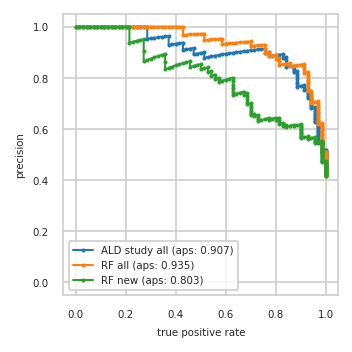

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


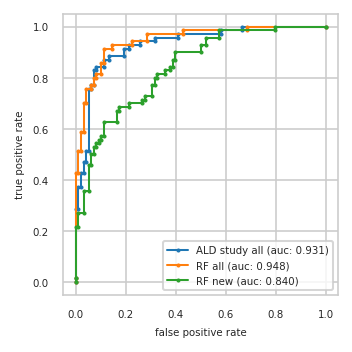

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}